In [67]:
pip install fredapi

In [68]:
from fredapi import Fred
import pandas as pd
pd.options.mode.chained_assignment = None

from collections import defaultdict
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import fbeta_score, roc_curve, roc_auc_score, accuracy_score, precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
import sklearn.exceptions as sklearn_except

%matplotlib inline

In [69]:
path = "C:/Users/Jeetesh/CAPSTONEEEE/CAPSTONE ALLOCATION/graphs/"

In [70]:
fred = Fred(api_key="373c1ab63543a01b4a3e5471bfa4b524")

T10Y3M = pd.Series(fred.get_series("T10Y3M"), name="T10Y3M")
unrate = pd.Series(fred.get_series("UNRATE"), name = "UNRATE")
NFCI = pd.Series(fred.get_series("NFCINONFINLEVERAGE"), name="NFCI")
us_rec = pd.Series(fred.get_series("USREC"), name="USREC")
DGS10 = pd.Series(fred.get_series("DGS10"), name="DGS10")
CPI = pd.Series(fred.get_series("CPIAUCSL"), name="CPI")

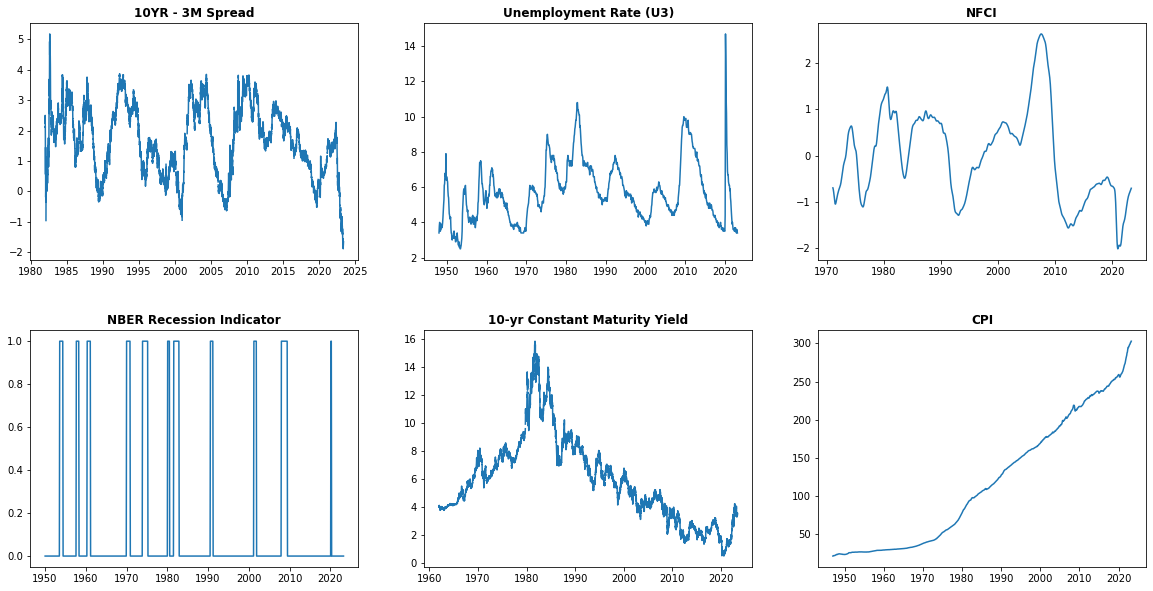

In [71]:
fig, axs = plt.subplots(2,3, figsize=(20,10), gridspec_kw = {"hspace":0.3})

axs[0][0].plot(T10Y3M)
axs[0][0].set_title("10YR - 3M Spread", weight="bold")

axs[0][1].plot(unrate)
axs[0][1].set_title("Unemployment Rate (U3)", weight="bold")

axs[0][2].plot(NFCI)
axs[0][2].set_title("NFCI", weight="bold")

# Recession data goes back to 1854, limit to more recent history
axs[1][0].plot(us_rec.loc[us_rec.index.year>=1950])
axs[1][0].set_title("NBER Recession Indicator", weight="bold")

axs[1][1].plot(DGS10)
axs[1][1].set_title("10-yr Constant Maturity Yield", weight="bold")

axs[1][2].plot(CPI)
axs[1][2].set_title("CPI", weight="bold");

In [72]:
df = pd.concat([T10Y3M, NFCI, unrate, us_rec, DGS10, CPI], axis=1)

In [73]:
df

,T10Y3M,NFCI,UNRATE,USREC,DGS10,CPI
1854-12-01,NaN,NaN,NaN,1.0,NaN,NaN
1855-01-01,NaN,NaN,NaN,0.0,NaN,NaN
1855-02-01,NaN,NaN,NaN,0.0,NaN,NaN
1855-03-01,NaN,NaN,NaN,0.0,NaN,NaN
1855-04-01,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...
2023-05-12,-1.79,-0.70528,NaN,NaN,3.46,NaN
2023-05-15,-1.71,NaN,NaN,NaN,3.50,NaN
2023-05-16,-1.69,NaN,NaN,NaN,3.54,NaN
2023-05-17,-1.69,NaN,NaN,NaN,3.57,NaN


In [74]:
year_month = pd.Series([str(x) for x in df.index.year.values]) + "-" + pd.Series([str(x) for x in df.index.month.values])
df["year_month"] = year_month.values

df = df.groupby("year_month")[["T10Y3M", "UNRATE", "NFCI", "USREC", "DGS10", "CPI"]].mean().dropna()

In [75]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI
year_month,,,,,,
1982-1,1.676000,8.6,0.956618,1.0,14.594000,94.4
1982-10,2.939000,10.4,0.180288,1.0,10.906500,98.1
1982-11,2.204211,10.8,0.082150,1.0,10.550526,98.0
1982-12,2.337273,10.8,-0.020836,0.0,10.540000,97.7
1982-2,0.146111,8.9,0.951312,1.0,14.425556,94.7


In [76]:
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.index.name = None

In [77]:
df["CPI_chg"] = df["CPI"].pct_change()

In [78]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg
1982-01-01,1.676000,8.6,0.956618,1.0,14.594000,94.4,NaN
1982-02-01,0.146111,8.9,0.951312,1.0,14.425556,94.7,0.003178
1982-03-01,0.546522,9.0,0.907035,1.0,13.861304,94.7,0.000000
1982-04-01,0.527143,9.3,0.814034,1.0,13.871905,95.0,0.003168
1982-05-01,0.908500,9.4,0.696495,1.0,13.622500,95.9,0.009474


In [79]:
SP500 = pd.read_csv("com.csv", index_col=0, header=0, names=["S&P500","divs_annualized"])

In [80]:
df = df.join(SP500)

In [81]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg,S&P500,divs_annualized
1982-01-01,1.676000,8.6,0.956618,1.0,14.594000,94.4,NaN,117.3,6.66
1982-02-01,0.146111,8.9,0.951312,1.0,14.425556,94.7,0.003178,114.5,6.69
1982-03-01,0.546522,9.0,0.907035,1.0,13.861304,94.7,0.000000,110.8,6.72
1982-04-01,0.527143,9.3,0.814034,1.0,13.871905,95.0,0.003168,116.3,6.75
1982-05-01,0.908500,9.4,0.696495,1.0,13.622500,95.9,0.009474,116.4,6.78


In [82]:
df["divs_monthly"] = df["divs_annualized"] / 12
df["S&P500_total_return"] = (df["S&P500"] + df["divs_monthly"]) / df["S&P500"].shift(1) - 1
df["real_S&P500_total_return"] = df["S&P500_total_return"] - df["CPI_chg"]

In [83]:
term = (df.index.max() - df.index.min()).days/365
print("S&P500 CAGR:",round((np.prod(df["S&P500_total_return"]+1)**(1/term) - 1)*100,2),"%")

S&P500 CAGR: 11.68 %


In [84]:
df["DGS10_prior"] = df["DGS10"].shift(1, fill_value=0)

In [85]:
df["treasury_return"] = (df["DGS10_prior"]/100*(1 - 1/(1 + df["DGS10"]/100)**10))/(df["DGS10"]/100) +\
                                            1/(1 + df["DGS10"]/100)**10 - 1 + df["DGS10_prior"]/100/12

In [86]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg,S&P500,divs_annualized,divs_monthly,S&P500_total_return,real_S&P500_total_return,DGS10_prior,treasury_return
1982-01-01,1.676000,8.6,0.956618,1.0,14.594000,94.4,NaN,117.3,6.66,0.5550,NaN,NaN,0.000000,-0.743917
1982-02-01,0.146111,8.9,0.951312,1.0,14.425556,94.7,0.003178,114.5,6.69,0.5575,-0.019118,-0.022296,14.594000,0.020804
1982-03-01,0.546522,9.0,0.907035,1.0,13.861304,94.7,0.000000,110.8,6.72,0.5600,-0.027424,-0.027424,14.425556,0.041613
1982-04-01,0.527143,9.3,0.814034,1.0,13.871905,95.0,0.003168,116.3,6.75,0.5625,0.054716,0.051548,13.861304,0.010995
1982-05-01,0.908500,9.4,0.696495,1.0,13.622500,95.9,0.009474,116.4,6.78,0.5650,0.005718,-0.003756,13.871905,0.024763


In [87]:
df["real_treasury_return"] = df["treasury_return"] - df["CPI_chg"]

df["treasury_return"].iloc[0]=0
df["real_treasury_return"].iloc[0]=0

In [88]:
df["rel_treasury_return"] = 1 + df["treasury_return"]
print((df.groupby(df.index.year)["rel_treasury_return"].prod()-1))
print("")
print(f"10-YR Treasury CAGR {df.index.min().year}-{df.index.max().year}:", np.prod(df["treasury_return"]+1)**(1/term)-1)

1982    0.405863
1983    0.034912
1984    0.152502
1985    0.272652
1986    0.244697
1987   -0.043218
1988    0.083241
1989    0.183095
1990    0.070959
1991    0.156965
1992    0.096370
1993    0.139835
1994   -0.072950
1995    0.240103
1996    0.020020
1997    0.104531
1998    0.151801
1999   -0.066019
2000    0.146605
2001    0.063159
2002    0.137817
2003    0.019965
2004    0.045861
2005    0.023734
2006    0.040605
2007    0.086701
2008    0.193444
2009   -0.066807
2010    0.057753
2011    0.152046
2012    0.042170
2013   -0.079287
2014    0.090052
2015    0.017820
2016   -0.004527
2017    0.031490
2018   -0.008954
2019    0.112959
2020    0.099358
2021   -0.035671
2022   -0.149589
2023    0.025214
Name: rel_treasury_return, dtype: float64

10-YR Treasury CAGR 1982-2023: 0.07283316314216481


In [89]:
df["USREC_shifted"] = df["USREC"].shift(-12, fill_value=0)

df[["USREC","USREC_shifted"]].iloc[-50:-35]

,USREC,USREC_shifted
2019-03-01,0.0,1.0
2019-04-01,0.0,1.0
2019-05-01,0.0,0.0
2019-06-01,0.0,0.0
2019-07-01,0.0,0.0
2019-08-01,0.0,0.0
2019-09-01,0.0,0.0
2019-10-01,0.0,0.0
2019-11-01,0.0,0.0
2019-12-01,0.0,0.0


In [90]:
df_SMA = df.copy()

In [91]:
df_SMA["T10Y3M_SMA"] = df_SMA["T10Y3M"].rolling(3).mean() 
df_SMA["UNRATE_SMA"] = df_SMA["UNRATE"].rolling(3).mean()
df_SMA["NFCI_SMA"] = df_SMA["NFCI"].rolling(3).mean()


df_SMA.dropna(inplace=True)

In [92]:
df_SMA.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg,S&P500,divs_annualized,divs_monthly,S&P500_total_return,real_S&P500_total_return,DGS10_prior,treasury_return,real_treasury_return,rel_treasury_return,USREC_shifted,T10Y3M_SMA,UNRATE_SMA,NFCI_SMA
1982-03-01,0.546522,9.0,0.907035,1.0,13.861304,94.7,0.000000,110.8,6.72,0.560000,-0.027424,-0.027424,14.425556,0.041613,0.041613,1.041613,0.0,0.789544,8.833333,0.938322
1982-04-01,0.527143,9.3,0.814034,1.0,13.871905,95.0,0.003168,116.3,6.75,0.562500,0.054716,0.051548,13.861304,0.010995,0.007827,1.010995,0.0,0.406592,9.066667,0.890794
1982-05-01,0.908500,9.4,0.696495,1.0,13.622500,95.9,0.009474,116.4,6.78,0.565000,0.005718,-0.003756,13.871905,0.024763,0.015289,1.024763,0.0,0.660722,9.233333,0.805855
1982-06-01,1.220909,9.6,0.586808,1.0,14.299545,97.0,0.011470,109.7,6.81,0.567500,-0.052685,-0.064155,13.622500,-0.023554,-0.035025,0.976446,0.0,0.885517,9.433333,0.699112
1982-07-01,2.082857,9.8,0.469304,1.0,13.946190,97.5,0.005155,109.4,6.82,0.568333,0.002446,-0.002709,14.299545,0.030386,0.025232,1.030386,0.0,1.404089,9.600000,0.584202


In [93]:
train_split = "2001-11-01"
train_split = datetime(int(train_split[0:4]), int(train_split[5:7]), int(train_split[9:11]))

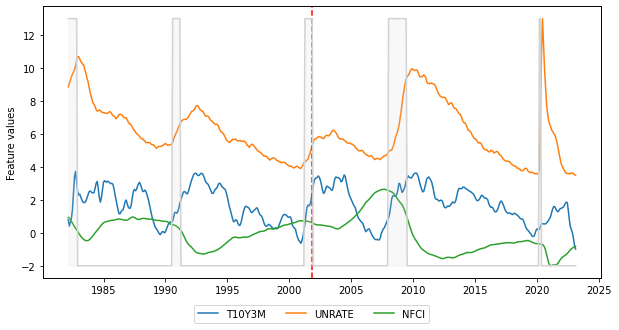

In [94]:
plt.figure(figsize=(10,5))
plt.plot(df_SMA.index, df_SMA["T10Y3M_SMA"], label="T10Y3M")
plt.plot(df_SMA["UNRATE_SMA"], label="UNRATE")
plt.plot(df_SMA["NFCI_SMA"], label="NFCI")
plt.legend(ncol=3, bbox_to_anchor=(0.70,-0.08), prop={"size": 10})
plt.ylabel("Feature values")
plt.axvline(train_split,color="r", linestyle="--")

ax1 = plt.twinx()
ax1.plot(df_SMA["USREC"], "lightgray", label="USREC")
ax1.fill_between(df_SMA.index,df_SMA["USREC"],color="lightgray",alpha=0.15)
ax1.get_yaxis().set_visible(False)

plt.savefig(path +"train_test_split.png", dpi=300);

In [95]:
T10Y3M_0 = df_SMA[df_SMA["USREC_shifted"]==0]["T10Y3M_SMA"]
T10Y3M_1 = df_SMA[df_SMA["USREC_shifted"]==1]["T10Y3M_SMA"]

UNRATE_0 = df_SMA[df_SMA["USREC_shifted"]==0]["UNRATE_SMA"]
UNRATE_1 = df_SMA[df_SMA["USREC_shifted"]==1]["UNRATE_SMA"]

NFCI_0 = df_SMA[df_SMA["USREC_shifted"]==0]["NFCI_SMA"]
NFCI_1 = df_SMA[df_SMA["USREC_shifted"]==1]["NFCI_SMA"]

C:\Users\Jeetesh\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Jeetesh\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Jeetesh\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

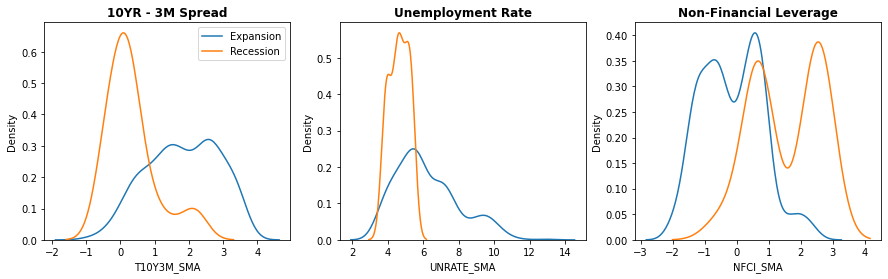

In [96]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
sns.distplot(T10Y3M_0, hist=False, ax=axs[0], label="Expansion")
sns.distplot(T10Y3M_1, hist=False, ax=axs[0], label="Recession")
axs[0].set_title("10YR - 3M Spread", weight="bold")
axs[0].legend()

sns.distplot(UNRATE_0, hist=False, ax=axs[1], label="Expansion")
sns.distplot(UNRATE_1, hist=False, ax=axs[1], label="Recession")
axs[1].set_title("Unemployment Rate", weight="bold")

sns.distplot(NFCI_0, hist=False, ax=axs[2], label="Expansion")
sns.distplot(NFCI_1, hist=False, ax=axs[2], label="Recession")
axs[2].set_title("Non-Financial Leverage", weight="bold")

plt.savefig(path + "distplot.png", dpi=300);

In [97]:
#print("Recessions account for:", "{:.1f}".format(df["USREC"].value_counts()[1]/df["USREC"].value_counts()[0]*100),"% of observations")

In [98]:
avg_exp_ret = df[df["USREC"] == 0]["S&P500_total_return"].mean()
avg_rec_ret = df[df["USREC"] == 1]["S&P500_total_return"].mean()

print(f"The S&P500 has mean monthly returns of {avg_exp_ret*100:.3f}% in expansions and mean \
monthly returns of {avg_rec_ret*100:.3f}% in recessions.")
beta = -avg_rec_ret / avg_exp_ret
print(f"Beta: {beta:.3f}")

The S&P500 has mean monthly returns of 1.155% in expansions and mean monthly returns of -0.557% in recessions.
Beta: 0.482


In [99]:
X = df_SMA[["T10Y3M_SMA","UNRATE_SMA","NFCI_SMA"]]
y = df_SMA["USREC_shifted"]

In [100]:
X_train = X[X.index <= train_split]
y_train = y[y.index <= train_split]
X_test = X[X.index > train_split]
y_test = y[y.index > train_split]


scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

In [101]:
warnings.filterwarnings("ignore", category=sklearn_except.UndefinedMetricWarning)


class_weights = [{0:weight, 1:1-weight} for weight in np.arange(0.05,1,0.05)]


first_rec = y_train[y_train.index=="1989-12-01"].index[0]
num_years = int((train_split-first_rec).days/365)

train_dates = [first_rec]+[first_rec + relativedelta(months=+12) * i for i in range(1,num_years)]

fbeta_dict = defaultdict(list)
for date in train_dates:
        X_train_cv = X_train[X_train.index <= date]
        y_train_cv = y_train[y_train.index <= date]
        X_test_cv = X_train[date+relativedelta(months=+1) : date + relativedelta(months=+12)]
        y_test_cv = y_train[date+relativedelta(months=+1) : date + relativedelta(months=+12)]
        
        for weight in class_weights:
            logistic_regression = LogisticRegression(random_state=4, class_weight=weight)
            logistic_regression.fit(X_train_cv, y_train_cv)
            preds = logistic_regression.predict(X_test_cv)
            fbeta = round(fbeta_score(y_test_cv,preds,beta=beta),4)
            
            if fbeta==0:
                pass
            else:
                fbeta_dict[str(weight)].append(fbeta)

In [102]:
max_fbeta = 0
for key, values in fbeta_dict.items():
    fbeta = np.mean(values)
    if fbeta > max_fbeta:
        max_fbeta = fbeta
        max_weights = key
max_weights = ast.literal_eval(max_weights)
print("max_weights:",max_weights)
print("Mean max fbeta:",max_fbeta)

max_weights: {0: 0.2, 1: 0.8}
Mean max fbeta: 0.8593500000000001


In [103]:
logistic_regression = LogisticRegression(random_state=4, class_weight=max_weights)
logistic_regression.fit(X_train_lr, y_train);

test_scores_lr = logistic_regression.predict_proba(X_test_lr)[:,1]
test_pred_lr = logistic_regression.predict(X_test_lr)

In [104]:
list(zip(X.columns,logistic_regression.coef_[0]))

[('T10Y3M_SMA', -1.8952006299019386),
 ('UNRATE_SMA', -0.5827259966655881),
 ('NFCI_SMA', 1.1386530556591814)]

In [105]:
def create_confusion_matrix(y_test, test_pred, test_scores, title, filename):
    c_matrix = confusion_matrix(y_test, test_pred)
    plt.figure(dpi=80)
    sns.heatmap(c_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
    xticklabels=['Expansion', 'Recession'],
    yticklabels=['Expansion', 'Recession'])
    plt.title(title,weight="bold")
    plt.xlabel('prediction',weight="bold",labelpad=10)
    plt.ylabel('actual',weight="bold",labelpad=10)
    
    print(f"ROC AUC: {roc_auc_score(y_test, test_scores):.3f}")
    print(f"F_{beta:.3f} Score: {fbeta_score(y_test, test_pred, beta):.3f}")
    print(f"Precision: {precision_score(y_test, test_pred):.3f}")
    print(f"Recall: {recall_score(y_test, test_pred):.3f}")
    print(f"Accuracy: {accuracy_score(y_test, test_pred):.3f}")
    #plt.savefig(path + filename + ".png", dpi=300)

ROC AUC: 0.961
F_0.482 Score: 0.510
Precision: 0.471
Recall: 0.800
Accuracy: 0.914


C:\Users\Jeetesh\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass beta=0.48188352486504604 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


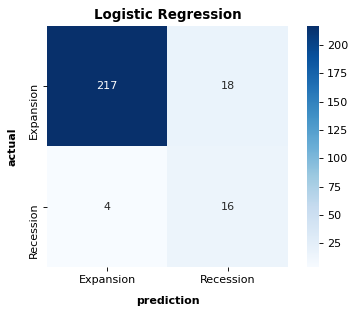

In [106]:
create_confusion_matrix(y_test, test_pred_lr, test_scores_lr, "Logistic Regression", "LR Confusion Matrix")

In [107]:
def plot_ROC_curves(y_test, test_scores, title, filename):
    fpr, tpr, _ = roc_curve(y_test, test_scores)
    plt.plot(fpr, tpr, label=f"{title}")

    x = np.linspace(0,1,1000)
    plt.plot(x, x, linestyle='--')

    plt.title(f"{title} ROC Curve", weight="bold")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    #plt.savefig(path + filename + ".png", dpi=300)

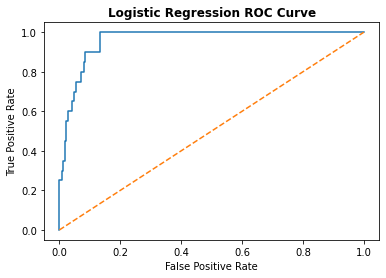

In [108]:
plot_ROC_curves(y_test, test_scores_lr, "Logistic Regression", "Logistic_Regression_ROC_AUC")

In [109]:
def plot_results(df, column_name, file_name, title):
    fig, axs = plt.subplots(2,figsize=(10,12))
    for col in X.columns:
        if "SMA" in col:
            label = label=col[:-4]
        else:
            label = col
        axs[0].plot(df[col], "--", label=label)
        
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axs[0].set_ylabel("Feature values")
    axs[0].set_title(title, weight="bold")
    axs[0].axvline(train_split,color="r")
    
    ax1 = axs[0].twinx()
    ax1.plot(df["USREC"], "lightgray")
    ax1.fill_between(df.index,df["USREC"],color="lightgray",alpha=0.25)
    ax1.plot(df[column_name], "maroon", label="REC_SCORE")
    ax1.set_ylabel("Recession Score", labelpad=5)

    fig.legend(ncol=4, bbox_to_anchor=(0.82,-0.1), bbox_transform=ax1.transAxes, prop={"size": 10})
    plt.subplots_adjust(hspace=.3)
    
    # Plot S&P500
    axs[1].plot(df.index, (1+df["S&P500_total_return"]).rolling(12).apply(np.prod, raw=True)-1, label="S&P500")
    axs[1].set_ylabel("S&P500 rolling 12-month return")
    axs[1].set_title("Recessions (shaded) with S&P500 Overlay", weight="bold")
 
    ax2 = axs[1].twinx()
    ax2.plot(df["USREC"], "lightgray", label="USREC")
    ax2.fill_between(df.index,df["USREC"],color="lightgray",alpha=.25)
    ax2.axes.get_yaxis().set_ticks([])
    axs[1].axhline(y=0, color="r", linestyle="-")
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    plt.savefig(path + file_name + ".png", dpi=300)

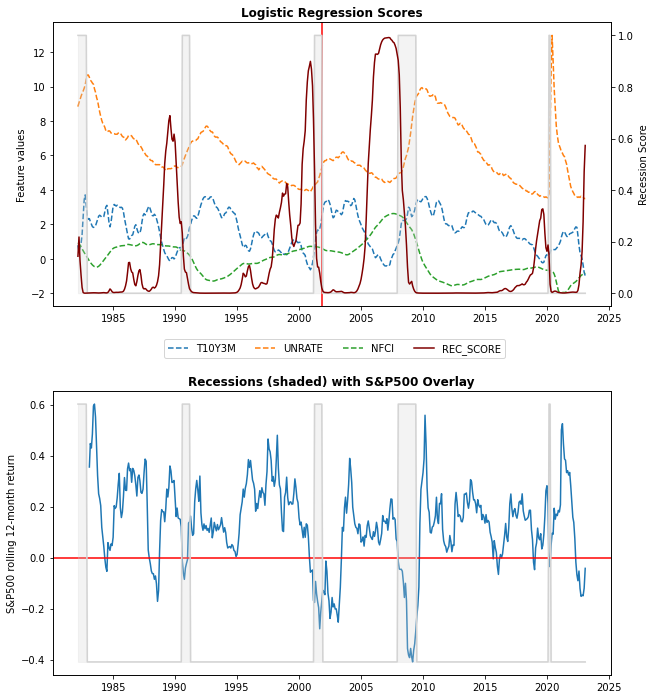

In [110]:
df_SMA["LogReg_rec_score"] = logistic_regression.predict_proba(scaler.transform(X))[:,1]
plot_results(df_SMA, "LogReg_rec_score", "Logistic_Regression_Output", "Logistic Regression Scores")

In [111]:
stock_weight = 0.6
bond_weight = round(1-stock_weight,1)
asset_mix = str(int(stock_weight*100)) + ":" + str(int(bond_weight*100)) + "_return"
portfolio_weights = [{"stocks":x, "bonds":1-x} for x in np.arange(0.1,stock_weight + 0.1,0.1)]

risk_off_scores = np.arange(0.05,1.0,0.05)
risk_on_scores = np.arange(0.05,1.0,0.05)

In [112]:
df_SMA["ttm_treasury_return"] = (1+(df_SMA["DGS10"].iloc[-12:].mean()/100))**(1/12)-1
df_SMA["60:40_return"] = 0.6 * df_SMA["S&P500_total_return"] + 0.4 * df_SMA["treasury_return"]
df_SMA["80:20_return"] = 0.8 * df_SMA["S&P500_total_return"] + 0.2 * df_SMA["treasury_return"]
df_SMA["100:0_return"] = df_SMA["S&P500_total_return"]

df_SMA["60:40_ttm_return"] = 0.6 * df_SMA["S&P500_total_return"] + 0.4 * df_SMA["ttm_treasury_return"]
df_SMA["80:20_ttm_return"] = 0.8 * df_SMA["S&P500_total_return"] + 0.2 * df_SMA["ttm_treasury_return"]

In [113]:
allocation_fields = ["LogReg_rec_score","USREC","S&P500_total_return","treasury_return","ttm_treasury_return",
                     "60:40_return","60:40_ttm_return","80:20_return","80:20_ttm_return","100:0_return"]

allocation_train = df_SMA[df_SMA.index <= train_split][allocation_fields]
allocation_test = df_SMA[df_SMA.index > train_split][allocation_fields]

In [114]:
allocation_train["stock_weight"] = stock_weight
allocation_train["bond_weight"] = bond_weight

In [115]:
max_return = 0


for risk_off_score in risk_off_scores:
    
    risk_off_dates = allocation_train[(allocation_train["LogReg_rec_score"] >= risk_off_score) &
                   (allocation_train["LogReg_rec_score"] > allocation_train["LogReg_rec_score"].shift(12,fill_value=0))].index

    
    days_between = [risk_off_dates[i+1] - risk_off_dates[i] for i in range(len(risk_off_dates)-1)]
    dates_zipped = list(zip(days_between,risk_off_dates[1:]))
    
    
    try:
        risk_off_starts = [risk_off_dates[0]+relativedelta(months=+1)] + [element[1]+relativedelta(months=+1) 
                                                                      for element in dates_zipped 
                                                                      if element[0].days > 365]
    except:
        continue
    
   
    for risk_on_score in risk_on_scores:
        try:
            risk_on_starts = [allocation_train[(allocation_train["LogReg_rec_score"]<=risk_on_score) & 
                                               (allocation_train["LogReg_rec_score"]<allocation_train["LogReg_rec_score"].shift(12,fill_value=0)) &
                                               (allocation_train.index > start)].index[0]+relativedelta(months=+1) 
                              for start in risk_off_starts]
        except:
            continue
        
        allocation_shift_cycles = list(zip(risk_off_starts,risk_on_starts))

        for weight in portfolio_weights:
            
            allocation_train["trading_rule_returns"] = allocation_train[asset_mix]

            
            for cycle in allocation_shift_cycles:
                allocation_train["stock_weight"].loc[cycle[0]:cycle[1]] = weight["stocks"]
                allocation_train["bond_weight"].loc[cycle[0]:cycle[1]] = weight["bonds"]
                allocation_train["trading_rule_returns"].loc[cycle[0]:cycle[1]] =\
                allocation_train["stock_weight"] * allocation_train["S&P500_total_return"] +\
                allocation_train["bond_weight"] * allocation_train["treasury_return"]

            
            trading_return = np.prod(1 + allocation_train["trading_rule_returns"])
            if trading_return > max_return:
                max_return = trading_return
                allocation_train["optimal_stock_weight"] = allocation_train["stock_weight"]
                allocation_train["optimal_bond_weight"] = allocation_train["bond_weight"]
                allocation_train["optimal_returns"] = allocation_train["trading_rule_returns"]
                rule_params = {"risk off score": risk_off_score,"risk on score": risk_on_score,"weights": weight}
            
print(f"Max cumulative return: {max_return:0.3f}")
print(f"Rule parameters: {rule_params}")


Max cumulative return: 18.099
Rule parameters: {'risk off score': 0.6000000000000001, 'risk on score': 0.1, 'weights': {'stocks': 0.1, 'bonds': 0.9}}


In [116]:
allocation_train.tail()

,LogReg_rec_score,USREC,S&P500_total_return,treasury_return,ttm_treasury_return,60:40_return,60:40_ttm_return,80:20_return,80:20_ttm_return,100:0_return,stock_weight,bond_weight,trading_rule_returns,optimal_stock_weight,optimal_bond_weight,optimal_returns
2001-07-01,0.101696,1.0,-0.026601,0.008075,0.002669,-0.012731,-0.014893,-0.019666,-0.020747,-0.026601,0.6,0.4,-0.012731,0.1,0.9,0.004608
2001-08-01,0.100851,1.0,-0.020457,0.024846,0.002669,-0.002336,-0.011207,-0.011397,-0.015832,-0.020457,0.6,0.4,-0.002336,0.1,0.9,0.020315
2001-09-01,0.077838,1.0,-0.112472,0.022883,0.002669,-0.058330,-0.066416,-0.085401,-0.089444,-0.112472,0.6,0.4,-0.058330,0.1,0.9,0.009347
2001-10-01,0.046304,1.0,0.031840,0.016952,0.002669,0.025885,0.020172,0.028863,0.026006,0.031840,0.6,0.4,0.025885,0.1,0.9,0.018441
2001-11-01,0.020623,1.0,0.050531,-0.002845,0.002669,0.029181,0.031386,0.039856,0.040959,0.050531,0.6,0.4,0.029181,0.6,0.4,0.029181


In [117]:
def show_returns(df):
    years = (df.index.max() - df.index.min()).days/365
    print(f"CAGR for constant {asset_mix[0:5]} portfolio:",round((np.prod(1 + df[asset_mix])**(1/years)-1)*100,2),"%")
    
    print("CAGR for trading rule portfolio:",round((np.prod(1 + df["optimal_returns"])**(1/years)-1)*100,2),"%")
    print("")
    print(f"Std Dev for constant {asset_mix[0:5]} portfolio: {np.std(df[asset_mix])*100:0.3f}%")
    print(f"Std Dev for trading rule portfolio: {np.std(df['optimal_returns'])*100:0.3f}%")

In [118]:
show_returns(allocation_train)

CAGR for constant 60:40 portfolio: 14.23 %
CAGR for trading rule portfolio: 15.85 %

Std Dev for constant 60:40 portfolio: 2.400%
Std Dev for trading rule portfolio: 2.243%


In [119]:
def plot_weights(df, train_test):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(df["optimal_stock_weight"],"--",label="Stock weight")
    ax.plot(df["optimal_bond_weight"],"--",label="Bond weight")
    ax.plot(df["LogReg_rec_score"],label="Model Score")
    ax.legend(loc="best")
    ax.set_ylabel("Portfolio weights & Model score")
    ax.set_yticks(np.arange(0, 1, 0.1))
    plt.subplots_adjust(hspace=0.4)
    
    ax1 = ax.twinx()
    ax1.plot(df["USREC"],"lightgray",label="USREC")
    ax1.fill_between(df.index,df["USREC"],color="lightgray",alpha=0.25)
    ax1.get_yaxis().set_visible(False)
    ax.legend(ncol=3, bbox_to_anchor=(0.8,-0.08), bbox_transform=ax1.transAxes, prop={"size": 10})
    
    

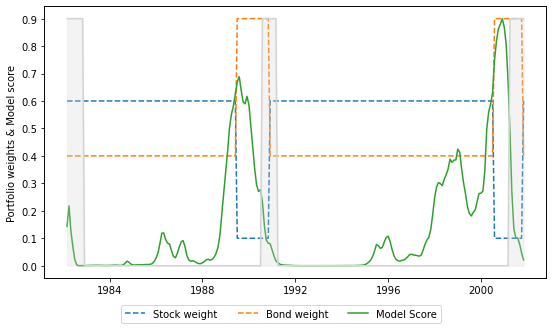

In [120]:
plot_weights(allocation_train, "train")
plt.savefig(path+"portfolio_while_training.png", dpi=300);

In [121]:
def plot_returns(df, train_test, title):
    start_amt = 100000
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(df.index,np.cumprod(1 + df["optimal_returns"])*start_amt, label="Trading Rule")
    ax.plot(np.cumprod(1 + df[asset_mix])*start_amt, label=asset_mix[0:5])
    ax.plot(np.cumprod(1 + df["treasury_return"])*start_amt, label="All Bonds")
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    ax.legend(ncol=3, bbox_to_anchor=(0.78,-0.08), prop={"size": 10})
    ax.set_ylabel("Growth of $10,000")
    
    ax1 = ax.twinx()
    ax1.plot(df["USREC"], "lightgray", label="USREC")
    ax1.fill_between(df.index,df["USREC"],color="lightgray",alpha=0.25)
    ax1.get_yaxis().set_visible(False)
    
   

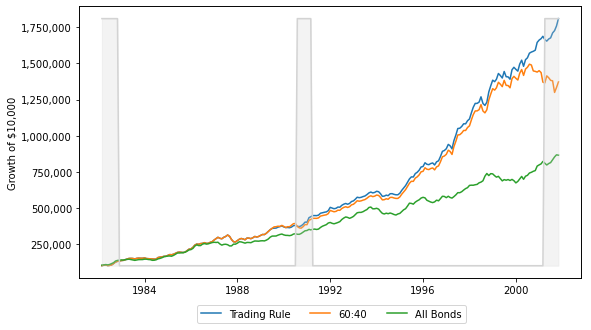

In [122]:
plot_returns(allocation_train, "train", "")
plt.savefig(path + "growth_of_100000_training.png", dpi=300);

In [123]:
portfolio_weights = rule_params["weights"]
risk_off_score = rule_params["risk off score"]
risk_on_score = rule_params["risk on score"]

allocation_test["optimal_returns"] = allocation_test[asset_mix]
allocation_test["optimal_stock_weight"] = stock_weight
allocation_test["optimal_bond_weight"] = bond_weight

# Create list of dates where model score is greater than risk_off_score being tested
test_risk_off_dates = allocation_test[(allocation_test["LogReg_rec_score"] >= risk_off_score) &
                   (allocation_test["LogReg_rec_score"] > allocation_test["LogReg_rec_score"]
                    .shift(12,fill_value=0))].index

# If no dates are marked as risk off dates, exit code
if test_risk_off_dates.empty:
    pass
else:
    # Calculate days between each successive date and create zip object combining dates and those days between 
    test_days_between = [test_risk_off_dates[i+1]-test_risk_off_dates[i] for i in range(len(test_risk_off_dates)-1)]
    test_dates_zipped = list(zip(test_days_between,test_risk_off_dates[1:]))

    # Create list of the first days where the risk_off_score is hit. Separate different periods by one year
    test_risk_off_starts = [test_risk_off_dates[0]+relativedelta(months=+1)]+[element[1]+relativedelta(months=+1) 
                                                                                    for element in test_dates_zipped if element[0].days > 365]

    # Iterate through the risk_off_start dates and find a corresponding end date at which to get back into stocks
    test_risk_on_starts = [allocation_test[(allocation_test["LogReg_rec_score"] <= risk_on_score) 
                                      & (allocation_test["LogReg_rec_score"] < allocation_test["LogReg_rec_score"]
                                         .shift(12,fill_value=0)) 
                                      & (allocation_test.index > start)].index[0]+relativedelta(months=+1) for start in test_risk_off_starts]

    test_allocation_shift_cycles = list(zip(test_risk_off_starts, test_risk_on_starts))

    for cycle in test_allocation_shift_cycles:
        allocation_test["optimal_stock_weight"].loc[cycle[0]:cycle[1]] = portfolio_weights["stocks"]
        allocation_test["optimal_bond_weight"].loc[cycle[0]:cycle[1]] = portfolio_weights["bonds"]
        allocation_test["optimal_returns"].loc[cycle[0]:cycle[1]] =\
        allocation_test["optimal_stock_weight"] * allocation_test["S&P500_total_return"] +\
        allocation_test["optimal_bond_weight"] * allocation_test["treasury_return"]

In [124]:
allocation_test.head()

,LogReg_rec_score,USREC,S&P500_total_return,treasury_return,ttm_treasury_return,60:40_return,60:40_ttm_return,80:20_return,80:20_ttm_return,100:0_return,optimal_returns,optimal_stock_weight,optimal_bond_weight
2001-12-01,0.008270,0.0,0.014660,-0.029648,0.002669,-0.003063,0.009864,0.005799,0.012262,0.014660,-0.003063,0.6,0.4
2002-01-01,0.004163,0.0,-0.002977,0.008231,0.002669,0.001506,-0.000719,-0.000735,-0.001848,-0.002977,0.001506,0.6,0.4
2002-02-01,0.003018,0.0,-0.033528,0.013823,0.002669,-0.014588,-0.019049,-0.024058,-0.026289,-0.033528,-0.014588,0.6,0.4
2002-03-01,0.002749,0.0,0.049452,-0.024272,0.002669,0.019963,0.030739,0.034708,0.040096,0.049452,0.019963,0.6,0.4
2002-04-01,0.002460,0.0,-0.035137,0.009990,0.002669,-0.017086,-0.020015,-0.026112,-0.027576,-0.035137,-0.017086,0.6,0.4


In [125]:
show_returns(allocation_test)

CAGR for constant 60:40 portfolio: 6.69 %
CAGR for trading rule portfolio: 8.04 %

Std Dev for constant 60:40 portfolio: 2.167%
Std Dev for trading rule portfolio: 2.006%


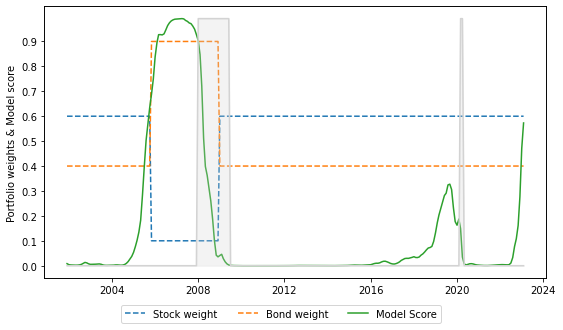

In [126]:
plot_weights(allocation_test, "test")
plt.savefig(path+"portfolio_while_testing.png", dpi=300);

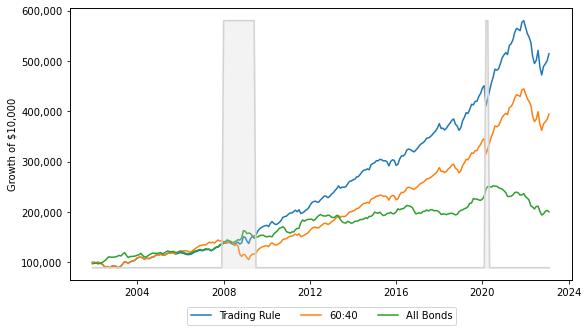

In [127]:
plot_returns(allocation_test, "test", "")
plt.savefig(path + "growth_of_100000_testing.png", dpi=300);

In [128]:
print("Ending investment of trading rule portfolio:",int(np.prod(1+allocation_test["optimal_returns"])*100000))
print("Ending investment of passive portfolio:",int(np.prod(1+allocation_test[asset_mix])*100000))
print("Ending investment of 100% bond portfolio:",int(np.prod(1+allocation_test["treasury_return"])*100000))

Ending investment of trading rule portfolio: 514322
Ending investment of passive portfolio: 394349
Ending investment of 100% bond portfolio: 200171


In [129]:
import tweepy
import logging
import os

In [130]:
import os

folder_path = "C:/Users/Jeetesh/CAPSTONEEEE/CAPSTONE ALLOCATION/graphs"
file_names = os.listdir(folder_path)

for file_name in file_names:
    print(file_name)

.ipynb_checkpoints
distplot.png
growth_of_100000_testing.png
growth_of_100000_training.png
Logistic_Regression_Output.png
portfolio_while_testing.png
portfolio_while_training.png
train_test_split.png


In [131]:

# import tweepy
# import os


# consumer_key = "your_consumer_key"
# consumer_secret = "your_consumer_secret"
# access_token = "your_access_token"
# access_token_secret = "your_access_token_secret"


# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)
# api = tweepy.API(auth)


# folder_path = "C:/Users/Jeetesh/CAPSTONEEEE/CAPSTONE ALLOCATION/graphs"
# file_names = os.listdir(folder_path)


# tweet_text = "Contents of {}:\n".format(folder_path)
# for file_name in file_names:
#     tweet_text += "- {}\n".format(file_name)


# api.update_status(tweet_text)


In [133]:
import os
import praw


reddit = praw.Reddit(
    client_id='AafGycDGu3wQSscM8k8vSQ',
    client_secret='5z9OHaIOJy4-U0U4Oc8U-Ux5lZlXrQ',
    username='LuckyAir7055',
    password='mountaindew7',
    user_agent='MyApp/0.1 by LuckyAir7055'
)


subreddit = reddit.subreddit('r/recessionanalysis')


folder_path = 'C:/Users/Jeetesh/CAPSTONEEEE/CAPSTONE ALLOCATION/graphs'


for file_name in os.listdir(folder_path):
    
    file_path = os.path.join(folder_path, file_name)

    
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        try:
            
            subreddit.submit_image(
                title=file_name,
                image_path=file_path,
                send_replies=False
            )
            print('Posted {} to Reddit'.format(file_name))
        except Exception as e:
            print('Failed to post {} to Reddit: {}'.format(file_name, e))


Posted distplot.png to Reddit
Posted growth_of_100000_testing.png to Reddit
Posted growth_of_100000_training.png to Reddit
Posted Logistic_Regression_Output.png to Reddit
Posted portfolio_while_testing.png to Reddit
Posted portfolio_while_training.png to Reddit
Posted train_test_split.png to Reddit
